# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from dython.nominal import cluster_correlations
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("./datasets/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./datasets/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./datasets/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./datasets/UCI HAR Dataset/test/y_test.txt").astype(int)


In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65** Это правильно
- 66
- 193

In [9]:
# Ваш код здесь
X_pca.shape

(10299, 65)

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51** Это правильно
- 56
- 61

In [10]:
# Ваш код здесь
pca.explained_variance_ratio_[0]

0.5073822103501334

Визуализируйте данные в проекции на первые две главные компоненты.

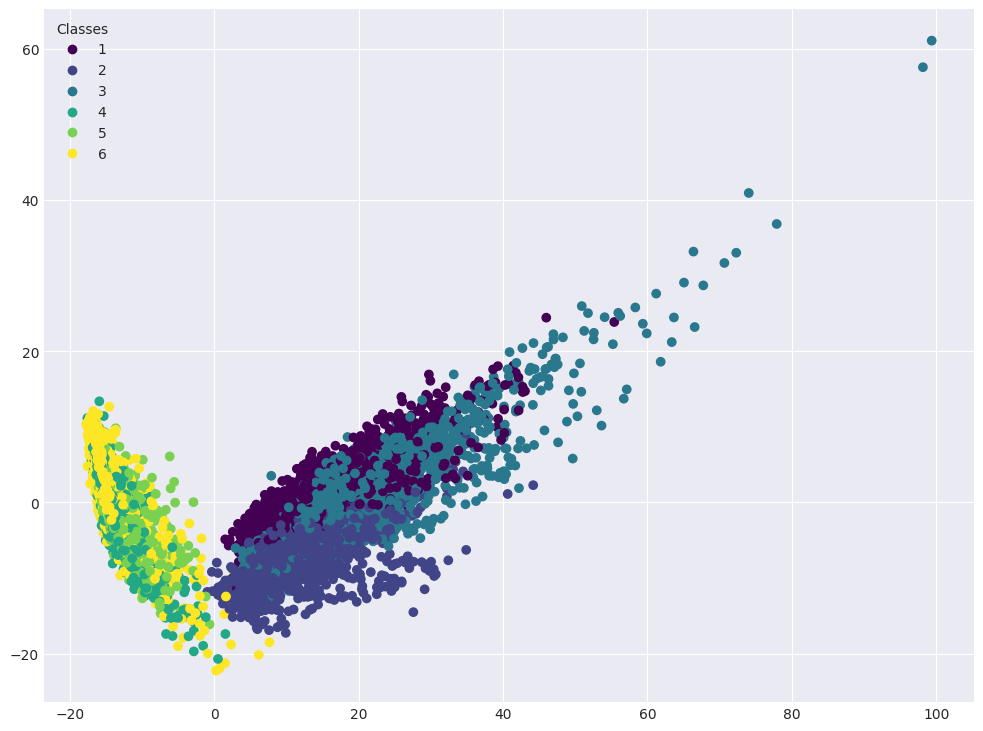

In [11]:
# Ваш код здесь
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Classes")

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)** Это правильно
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
class KMeansCustom:
    def __init__(self, n_clusters=10, n_init=100, max_iter=100, tol=1e-4, random_state=RANDOM_STATE):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = np.inf
        self.n_iter_ = -1

    def fit(self, X, y=None):
        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError("X должен быть 2D массивом.")

        n_samples, n_features = X.shape

        if self.n_clusters > n_samples:
            raise ValueError(f"n_clusters ({self.n_clusters}) > n_samples ({n_samples})")

        np.random.seed(self.random_state)

        best_inertia = np.inf
        best_labels = None
        best_centroids = None
        best_n_iter = 0

        for _ in range(self.n_init):
            idx = np.random.choice(n_samples, self.n_clusters, replace=False)
            centroids = X[idx].copy()

            for n_iter in range(1, self.max_iter + 1):
                distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
                labels = np.argmin(distances, axis=1)

                new_centroids = np.empty_like(centroids)
                for i in range(self.n_clusters):
                    mask = (labels == i)
                    if np.any(mask):
                        new_centroids[i] = X[mask].mean(axis=0)
                    else:
                        new_centroids[i] = centroids[i]

                if np.linalg.norm(new_centroids - centroids) < self.tol:
                    centroids = new_centroids
                    break

                centroids = new_centroids
            else:
                n_iter = self.max_iter

            assigned_centroids = centroids[labels]
            inertia = np.sum((X - assigned_centroids) ** 2)

            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()
                best_n_iter = n_iter

        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iter_ = best_n_iter

        return self

    def predict(self, X):
        if self.n_iter_ == -1:
            raise ValueError("Модель не обучена. Сначала вызовите .fit().")
        X = np.asarray(X)
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

    def score(self, X, y=None):
        if self.n_iter_ == -1:
            raise ValueError("Модель не обучена.")
        labels = self.predict(X)
        assigned_centroids = self.cluster_centers_[labels]
        inertia = np.sum((X - assigned_centroids) ** 2)
        return -inertia

Использование реализованного класса и класса из sklearn

In [13]:
km_custom = KMeansCustom(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
km_sklearn = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)

km_custom.fit(X_pca)
km_sklearn.fit(X_pca)

print("Custom inertia:", km_custom.inertia_)
print("Sklearn inertia:", km_sklearn.inertia_)

Custom inertia: 2003454.2018751244
Sklearn inertia: 2003454.8999158181


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

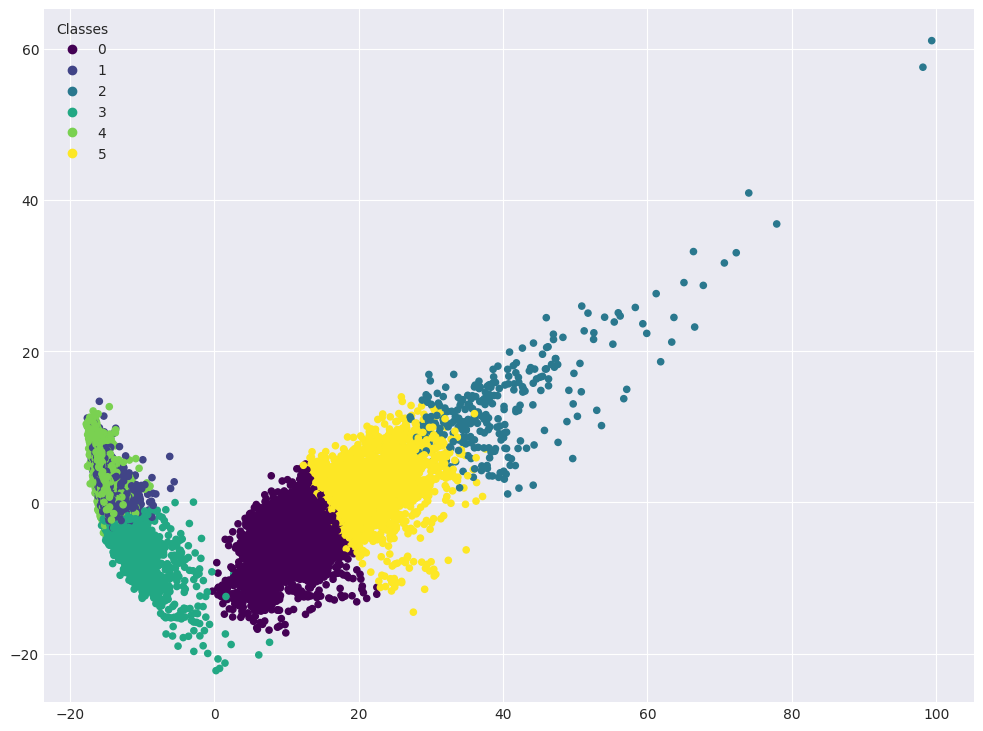

In [14]:
# Ваш код здесь
cluster_labels = km_custom.predict(X_pca)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');
plt.legend(*scatter.legend_elements(), title="Classes")

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [15]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


- Ходьба = 0.52
- Подъём = 0.80246
- Спуск = 0.63
- Сидение = 0.69
- Стояние = 0.71
- Лежание = 0.80144

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят** Этот правильный

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████| 6/6 [00:44<00:00,  7.34s/it]


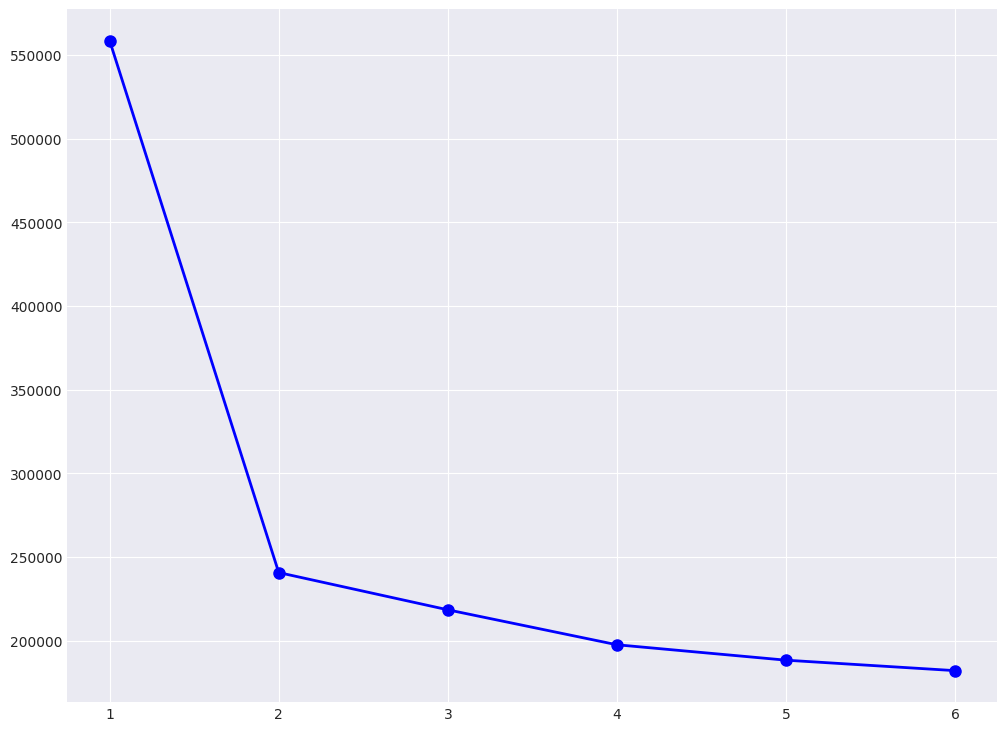

In [16]:
# Ваш код здесь
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, n_classes + 1), inertia, 'bo-', linewidth=2, markersize=8)

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2** Это правильно
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [17]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit_predict(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [18]:
# Ваш код здесь
km = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
km.fit(X_pca)
ari_ag = metrics.adjusted_rand_score(y, ag)
ari_km = metrics.adjusted_rand_score(y, km.labels_)
print(f"Агломеративная кластеризация: {ari_ag} \nКластеризация KMeans: {ari_km}")

Агломеративная кластеризация: 0.49362763373004886 
Кластеризация KMeans: 0.4198070012602345


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [19]:
# Ваш код здесь
scaler_new = StandardScaler()
X_train_scaled = scaler_new.fit_transform(X_train)
X_test_scaled = scaler_new.transform(X_test)

In [20]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(
    svc,
    svc_params,
    cv=3
)

grid.fit(X_train_scaled, y_train)


C:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [21]:
# Ваш код здесь
best_svc = grid.best_estimator_

In [22]:
# Ваш код здесь
grid.best_params_['C']

0.1

**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1** Это верно
- 1
- 10

In [23]:
y_predicted = best_svc.predict(X_test_scaled)

In [24]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [25]:
activnosty = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание']

for cls in activnosty:
    tp = tab.loc[cls, cls]
    pred_total = tab.loc['все', cls]
    true_total = tab.loc[cls, 'все']

    precision = tp / pred_total
    recall = tp / true_total

    print(f"{cls}: Точность - {precision:.4f}, Полнота - {recall:.4f}")

ходьба: Точность - 0.9724, Полнота - 0.9960
подъем вверх по лестнице: Точность - 0.9787, Полнота - 0.9745
спуск по лестнице: Точность - 1.0000, Полнота - 0.9833
сидение: Точность - 0.9638, Полнота - 0.8676
стояние: Точность - 0.8778, Полнота - 0.9718
лежание: Точность - 1.0000, Полнота - 0.9795


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние** Это правильно

In [26]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
svc_new = LinearSVC(random_state=RANDOM_STATE)
svc_params_new = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_new = GridSearchCV(
    svc_new,
    svc_params_new,
    cv=3
)

grid_new.fit(X_train_pca, y_train)

best_svc_new = grid_new.best_estimator_

grid_new.best_score_ - grid.best_score_


-0.03958023519485321

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%** Это правильно
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

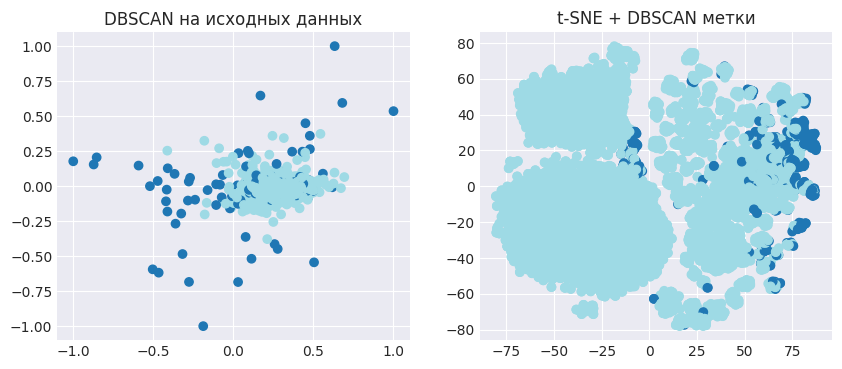

In [27]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=17, min_samples=15)
labels = dbscan.fit_predict(X_pca)

# t-SNE для визуализации
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# Визуализация
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab20')
plt.title("DBSCAN на исходных данных")

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab20')
plt.title("t-SNE + DBSCAN метки")

plt.show()